# Machine Learning for Medicine
# PCA
> * **Merrouche Aymen**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.model_selection import cross_validate
from collections import defaultdict

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data

## Import medical data :

### Breast cancer data set : 
> Describes wheather a breast mas is malignant or not based on cell nuclei characteristics.

In [3]:
# import the data
breast_cancer = pd.read_csv("data/Breast.txt",sep=" ")
breast_cancer_y = breast_cancer.values[:,30] # Classes
breast_cancer_X = breast_cancer.values[:,0:29] # Observations

In [4]:
print("Number of examples :", breast_cancer_X.shape[0])
print("Dimension of the problem :", breast_cancer_X.shape[1])
print("Number of classes :", np.unique(breast_cancer_y).shape[0])

Number of examples : 568
Dimension of the problem : 29
Number of classes : 2


### For the Golub et al. 1999 dataset :
> Molecular classification of leukemia data set of Golub et al. 1999 contains gene expressions of 72 patients and 3562 genes.

In [5]:
golub_X = pd.read_csv('data/Golub_X',sep=' ') # Observations
golub_y = pd.read_csv('data/Golub_y',sep=' ') # Classes

In [6]:
print("Number of examples :", golub_X.shape[0])
print("Dimension of the problem :", golub_X.shape[1])
print("Number of classes :", np.unique(golub_y).shape[0])

Number of examples : 71
Dimension of the problem : 3562
Number of classes : 2


In [7]:
medical_data = {"breast" : (pd.DataFrame(breast_cancer_X), breast_cancer_y), "golub" : (golub_X, np.squeeze(golub_y.values, axis=1))}

# 1 - Metrics :

# 1 - PCA to Cluster the Observations :
> In this section we perform pricipal compoent analysis on our two medical datasets. We visualise the results for a number of components of 2 and 3. To evaluate the quality of clustering, we will use a sparability measure, namely :
>* **Silhouette Coefficient :** Silhouette Coefficient for a sample is $\frac{(b - a)}{\max{(a, b)}}$. where :
    * b is the distance of the sample to the cluster center.
    * a is the distance of the sample to  the nearest cluster that the sample is not a part of. <br>
the mean silhouette coefficient is returned (best 1, worst -1).

## 1-1- Number of components = 2 :

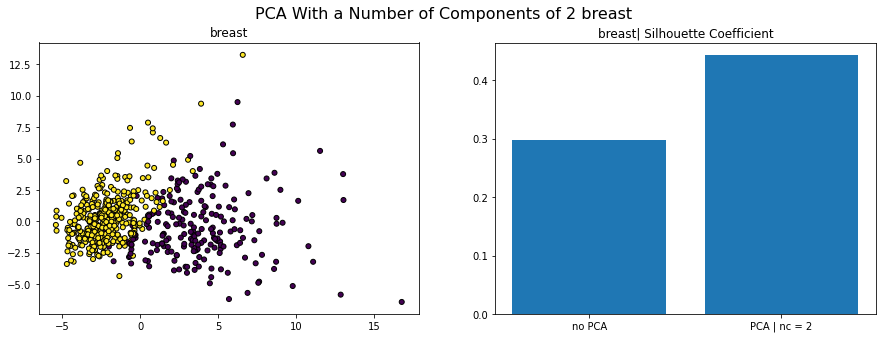

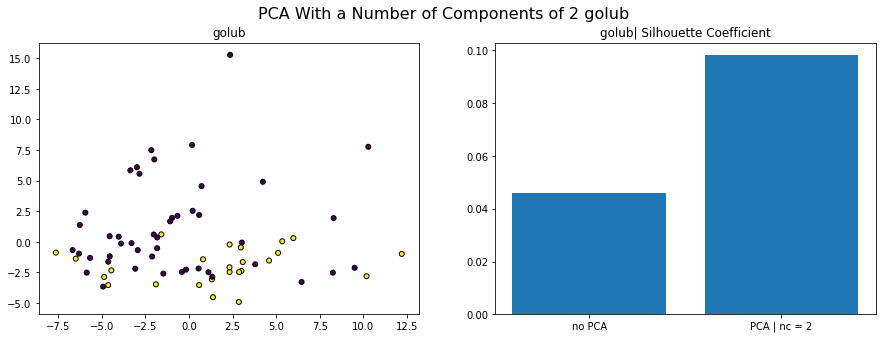

In [8]:
# use sklearn's pca
n_components = 2
pca = PCA(n_components=n_components)
# logging scores
scores = {}
for i,configuration in enumerate(medical_data):
    X, y = medical_data[configuration]
    # plot
    plt.figure(figsize=(15, 5))
    plt.suptitle("PCA With a Number of Components of 2 "+configuration, fontsize=16)
    # current plot
    ax = plt.subplot(1, 2, 1)
    ax.set_title(str(configuration))
    # fit the data and transform
    pca.fit(X)
    X_pca = pca.transform(X)
    # plot results
    plt.scatter(X_pca[:, 0], X_pca[:, 1],marker="o", c=y,s=25, edgecolor="k")
    # scores :
    scores[configuration] = {}
    scores[configuration]["no PCA"] =  metrics.silhouette_score(X, y)
    scores[configuration]["PCA | nc = "+str(n_components)] =  metrics.silhouette_score(X_pca, y)
    # plot scores
    ax = plt.subplot(1, 2, 2)
    ax.set_title(str(configuration)+"| Silhouette Coefficient")
    plt.bar(range(len(scores[configuration])), list(scores[configuration].values()), align='center')
    plt.xticks(range(len(scores[configuration])), list(scores[configuration].keys()))

> From the visualisation, in both datasets, we clearly see that PCA allows to cluster the data. This is also visible with the silhouette coefficient when compared on the original datamatrix and on the one outputted by PCA. This is an expected result, since PCA finds the combination of attributes (principal components or directions in the feature space) that account for the most variance in the data, so we would expect these directions to be discriminative with respect to the different classes. In fact, there is a strong connection between PCA and Kmeans. One way to see this is that K-means is a sparse PCA. Where PCA represents all data points as a linear combination of some number of eigenvectors, K-means represents the data points as a linear combination of the different cluster centroids ($1$ if the datapoint is a member of the corresponding cluster and $0$ otherwise), and then both methods minimise the reconstruction error ($l_2$ distance between data matrix and it's reconstruction).

## 1-2- Number of components = 3 :

In [9]:
def visiualise_3D_clustering(X, y, fig, position, title = "", labels = [('class 1', 0), ('class 2', 1)]):
    """
    Visualise 3D clustering results, Adapted from :
        # Code source: Gaël Varoquaux
        # License: BSD 3 clause
        # https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py
    :param X: clustered matrix
    :param y: true repartition
    :param fig: plt figure object of where to plot
    :param labels: dict{"label for class i", i}, i in {0,..,nb_classes}
    """  
    ax = fig.add_subplot(position,projection='3d')
    ax.view_init(25, 100)
    #ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    for name, label in labels:
        ax.text3D(X[y == label, 0].mean(),
                  X[y == label, 1].mean() + 1.5,
                  X[y == label, 2].mean(), name,
                  horizontalalignment='center',
                  bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    # Reorder the labels to have colors matching the cluster results
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Set1,
               edgecolor='k')
    
    ax.set_title(title)
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

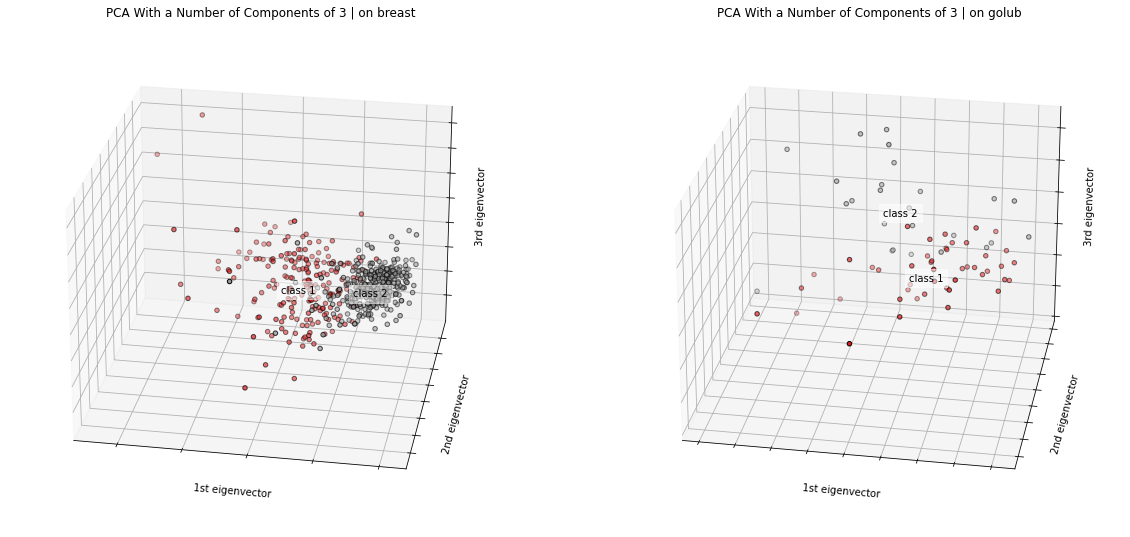

In [10]:
labels = {"breast" : [('class 1', 0), ('class 2', 1)], "golub" : [('class 1', 0), ('class 2', 1)]}
# use sklearn's pca
n_components = 3
pca = PCA(n_components=n_components)
# to visualise
fig = plt.figure(figsize=(20, 20))
for i,configuration in enumerate(medical_data):
    # get data and perform pca
    X, y = medical_data[configuration]
    pca.fit(X)
    X_pca = pca.transform(X)
    # log scores
    scores[configuration]["PCA | nc = "+str(n_components)] =  metrics.silhouette_score(X_pca, y)
    # plot results
    
    title = ("PCA With a Number of Components of 3 | on "+configuration) # title of subplot
    visiualise_3D_clustering(X_pca, np.where(y == -1, 0, y), fig=fig, position = 12*10+(i+1), title = title, labels = labels[configuration])
plt.show()

> visually PCA, each class occupies a part of the space however the two clusters are not linearly separable. Let's compare the PCA result's sealability for a number of components of $2$ vs a number of components of $3$ :

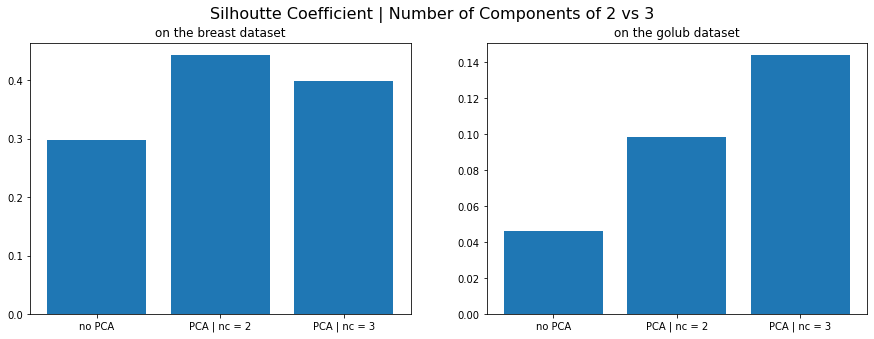

In [11]:
# plot
plt.figure(figsize=(15, 5))
plt.suptitle("Silhoutte Coefficient | Number of Components of 2 vs 3 ", fontsize=16)
for i,configuration in enumerate(medical_data):
    # current plot
    ax = plt.subplot(1, 2, i+1)
    ax.set_title("on the "+str(configuration)+" dataset")
    plt.bar(range(len(scores[configuration])), list(scores[configuration].values()), align='center')
    plt.xticks(range(len(scores[configuration])), list(scores[configuration].keys()))

> For both number of components, PCA yields a higher silhouette coefficient than the raw datamatrix. For the golub dataset we get a higher silhouette coefficient with a number of components is $3$. Inversely, for the breast dataset we get a higher silhouette coefficient with a number of components is $2$.

# 2 - Kernel PCA :
> In this section we will perform kernel PCA on our medical datasets and visualise the results. We will test different kernel :
>* Linear kernel (**exactly equivalent to the standard PCA**). 
>* Polynomial kernel (degree $2$).
>* Radial basis function kernel. 
>* Hyperbolic tangent (Sigmoid) kernel.
>* Cosine kernel.

In [12]:
kernels = ['linear', 'poly', 'sigmoid', 'cosine', 'rbf']

## 2-1- With a number of componenets of 2 :

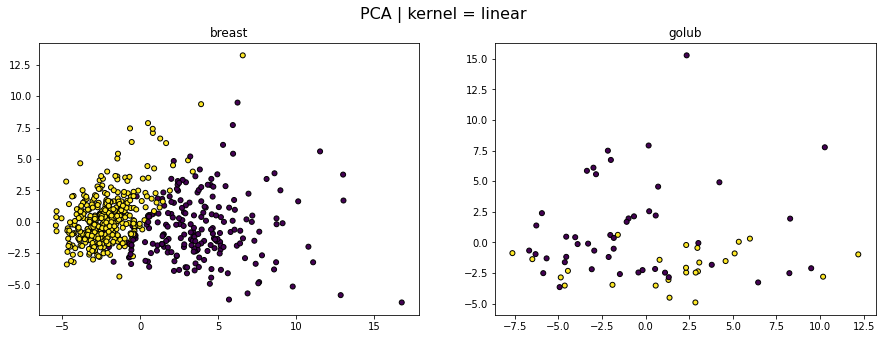

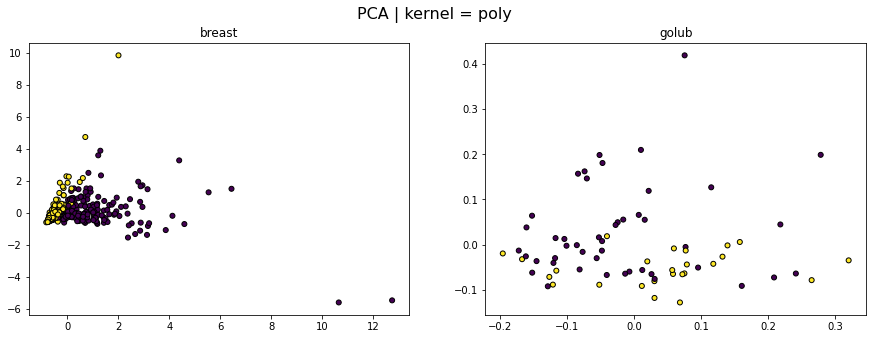

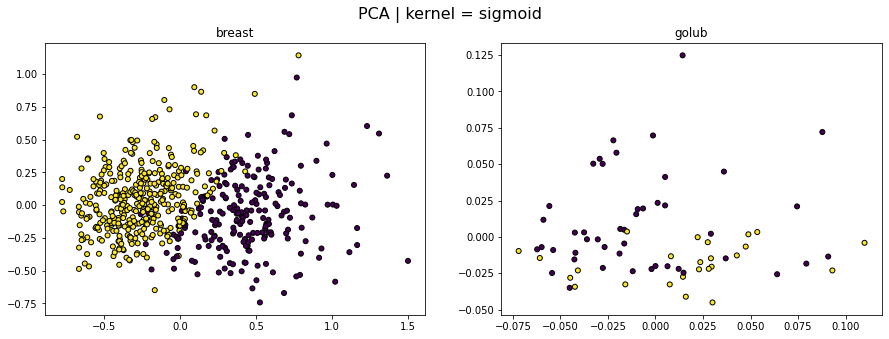

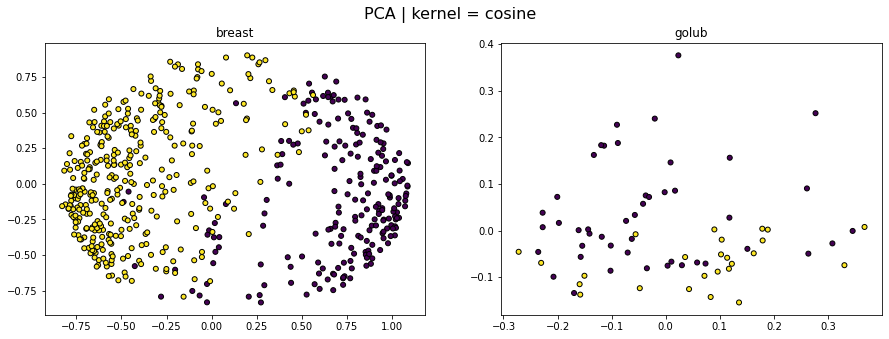

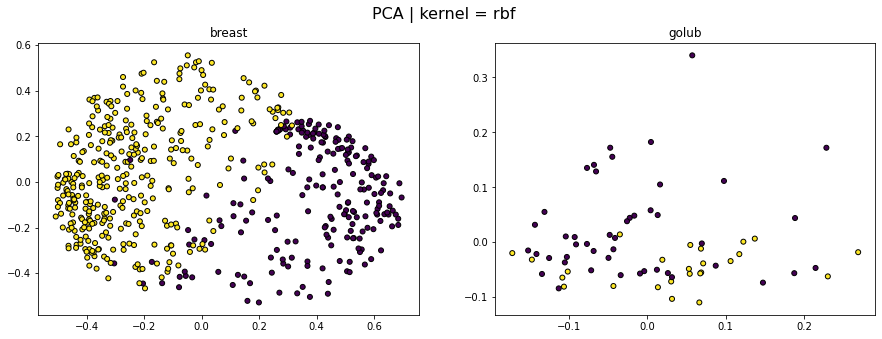

In [13]:
# logging score
scores_kpca = {}
for kernel in kernels:
    scores_kpca[kernel] = {}
    plt.figure(figsize=(15, 5))
    plt.suptitle("PCA | kernel = "+str(kernel), fontsize=16)
    for i,configuration in enumerate(medical_data):
        scores_kpca[kernel][configuration] = {}
        # define the kernel
        kpca = KernelPCA(n_components = 2,kernel=kernel, degree = 2)
        # get the data
        X, y = medical_data[configuration]
        # current plot
        ax = plt.subplot(1, 2, i+1)
        ax.set_title(str(configuration))
        # fit the data and transform
        kpca.fit(X)
        X_pca = kpca.transform(X)
        # log scores
        scores_kpca[kernel][configuration] =  metrics.silhouette_score(X_pca, y)
        # plot results
        plt.scatter(X_pca[:, 0], X_pca[:, 1],marker="o", c=y,s=25, edgecolor="k")

> We get very similar results on the golub dataset with the different kernels. Inversely, with the breast dataset, the results are very dissimilar. Let's compare the silhouette coefficient obtained with the different kernels :

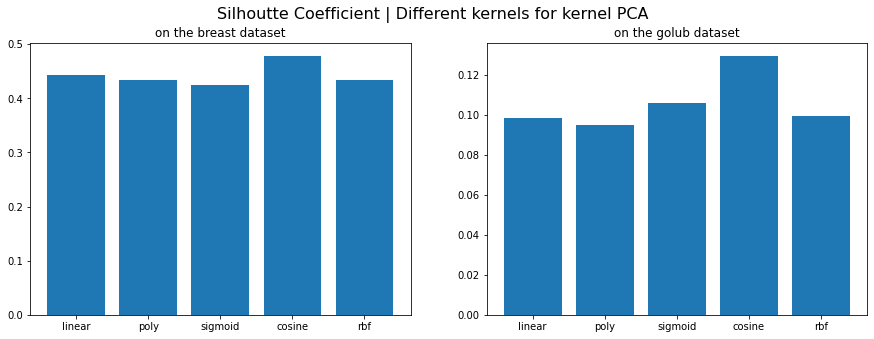

In [14]:
# reverse the dictionnary for plotting purposes
flipped_scores_kpca = defaultdict(dict)
for key, val in scores_kpca.items():
    for subkey, subval in val.items():
        flipped_scores_kpca[subkey][key] = subval
flipped_scores_kpca = dict(flipped_scores_kpca)
# plot
plt.figure(figsize=(15, 5))
plt.suptitle("Silhoutte Coefficient | Different kernels for kernel PCA ", fontsize=16)
for i,configuration in enumerate(medical_data):
    # current plot
    ax = plt.subplot(1, 2, i+1)
    ax.set_title("on the "+str(configuration)+" dataset")
    plt.bar(range(len(flipped_scores_kpca[configuration])), list(flipped_scores_kpca[configuration].values()), align='center')
    plt.xticks(range(len(flipped_scores_kpca[configuration])), list(flipped_scores_kpca[configuration].keys()))

> For both datasets, there are kernels that give a depredated silhouette coefficient when compared to plain PCA (breast : polynomial, sigmoid, rbf  | golub : polynomial, rbf). The cosine kernel yields the best silhouette coefficient for both datasets.

## 2-1- With a number of componenets of 3 :

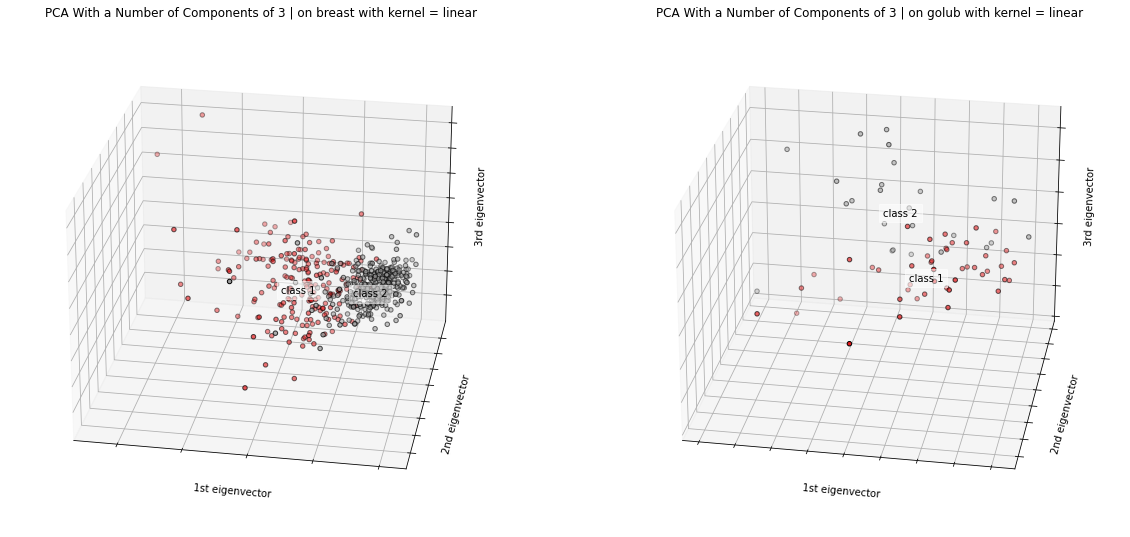

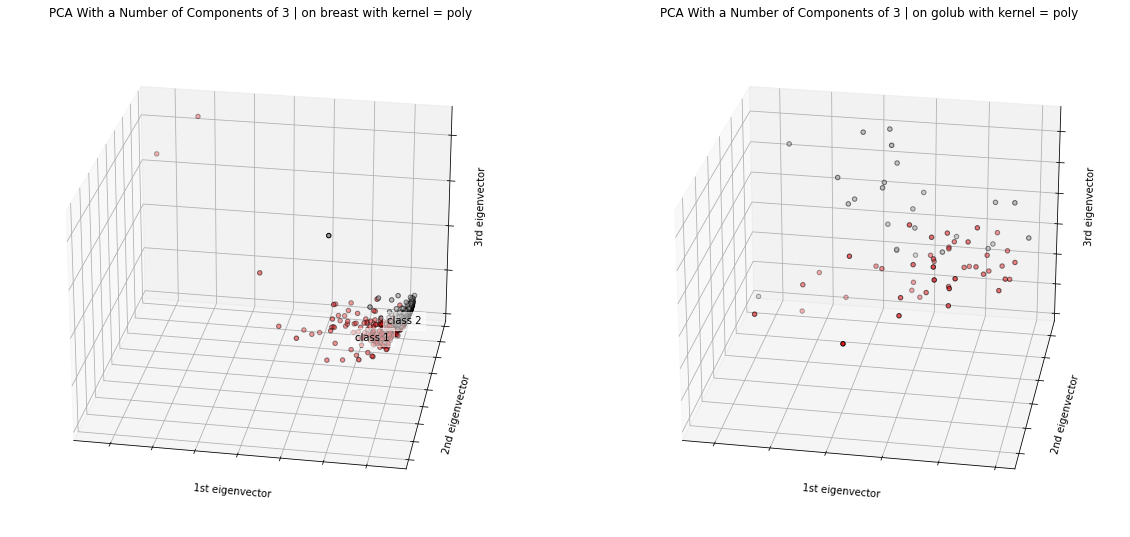

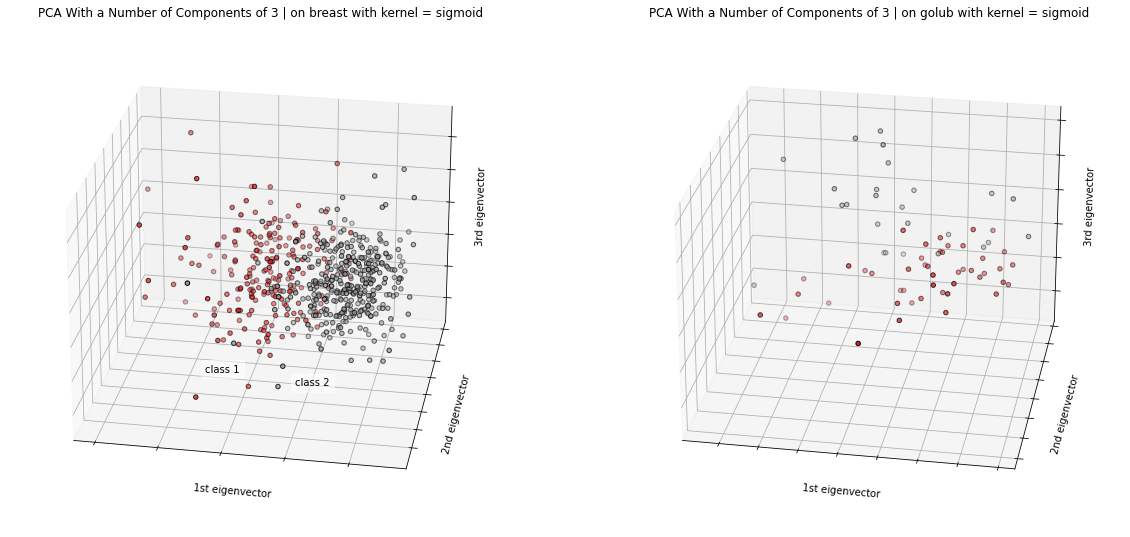

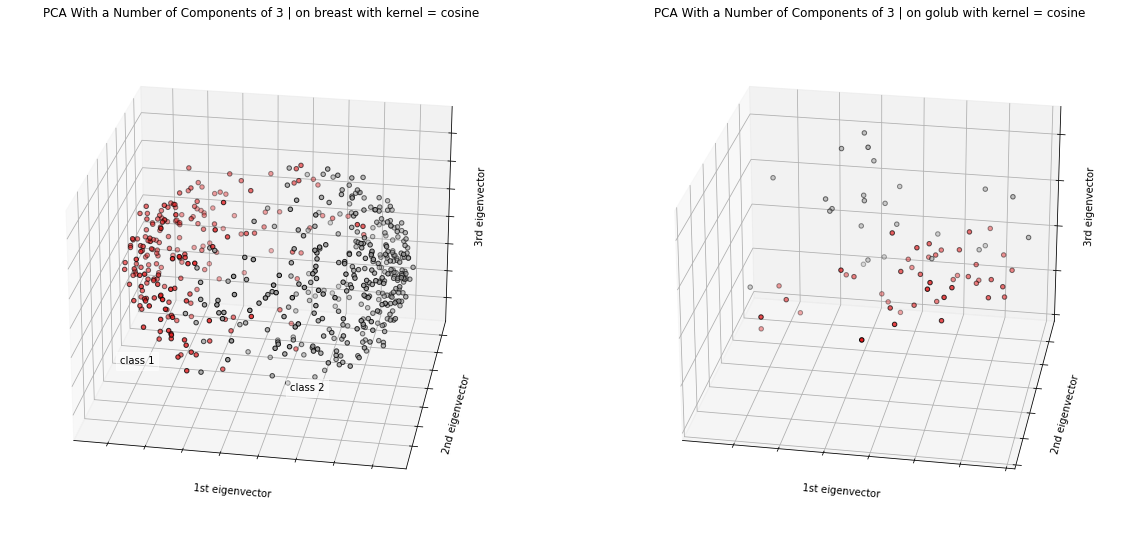

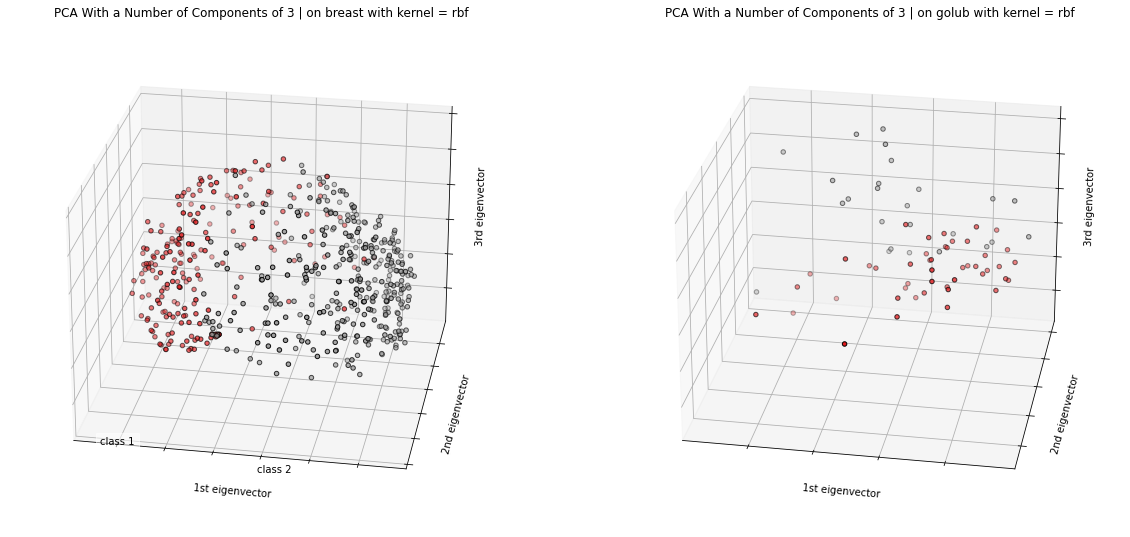

In [15]:
# logging score
scores_kpca_nb = {}
for kernel in kernels:
    scores_kpca_nb[kernel] = {}
    fig = plt.figure(figsize=(20, 20))
    for i,configuration in enumerate(medical_data):
        scores_kpca_nb[kernel][configuration] = {}
        # define the kernel
        kpca = KernelPCA(n_components = 3,kernel=kernel, degree = 2)
        # get the data
        X, y = medical_data[configuration]
        # current plot
        ax = plt.subplot(1, 2, i+1)
        ax.set_title(str(configuration))
        # fit the data and transform
        kpca.fit(X)
        X_pca = kpca.transform(X)
        # log scores
        scores_kpca_nb[kernel][configuration] =  metrics.silhouette_score(X_pca, y)
        # plot results
        title = ("PCA With a Number of Components of 3 | on "+configuration+" with kernel = "+kernel) # title of subplot
        visiualise_3D_clustering(X_pca, np.where(y == -1, 0, y), fig=fig, position = 12*10+(i+1), title = title, labels = labels[configuration])
plt.show()

> visually, we observe a similar behaviour with the case of $2$ components. Let's compare the silhouette coefficient for different kernels in this case :

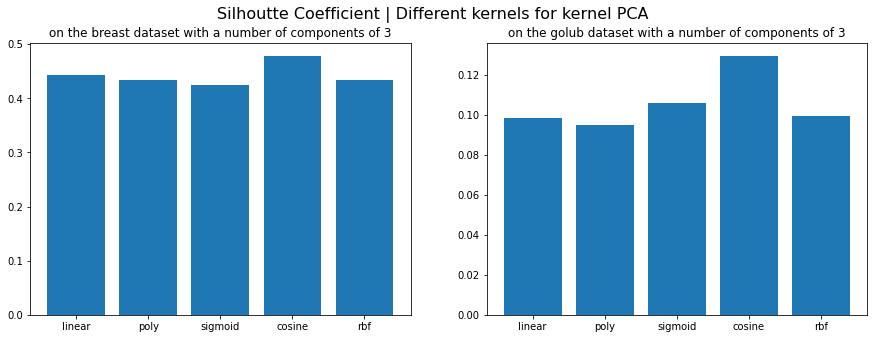

In [16]:
# reverse the dictionnary for plotting purposes
flipped_scores_kpca_nb = defaultdict(dict)
for key, val in scores_kpca_nb.items():
    for subkey, subval in val.items():
        flipped_scores_kpca_nb[subkey][key] = subval
flipped_scores_kpca_nb = dict(flipped_scores_kpca)
# plot
plt.figure(figsize=(15, 5))
plt.suptitle("Silhoutte Coefficient | Different kernels for kernel PCA ", fontsize=16)
for i,configuration in enumerate(medical_data):
    # current plot
    ax = plt.subplot(1, 2, i+1)
    ax.set_title("on the "+str(configuration)+" dataset"+" with a number of components of 3")
    plt.bar(range(len(flipped_scores_kpca_nb[configuration])), list(flipped_scores_kpca_nb[configuration].values()), align='center')
    plt.xticks(range(len(flipped_scores_kpca_nb[configuration])), list(flipped_scores_kpca_nb[configuration].keys()))

> We observe a similar silhouette coefficient behaviour with the case of $2$ components.

# 3 - Incremental PCA :
> In this section we will perform Incremental PCA on our medical datasets and visualise the results. IPCA builds a low-rank approximation for the input data using an amount of memory which is independent of the number of input data samples. We visualise the results for PCA and IPCA and also display the mean absolute error between matrices obtained in each case (PCA IPCA)

## 3-1- With a number of componenets of 2 :

In [17]:
# Number of componenets to use
n_components = 2
# colors to use for each class in the scatter plot
colors = ['navy', 'darkorange']

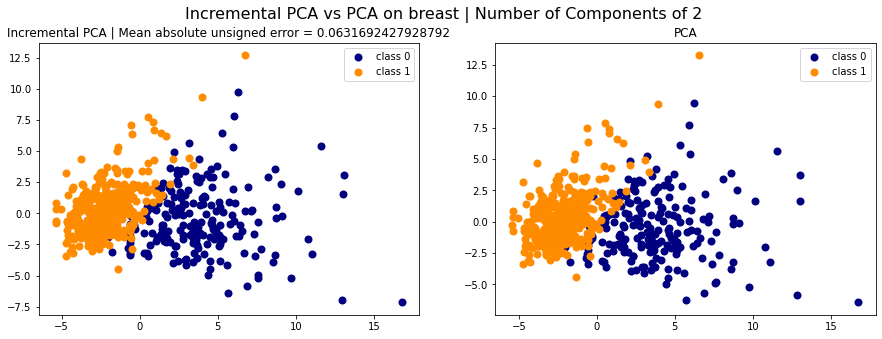

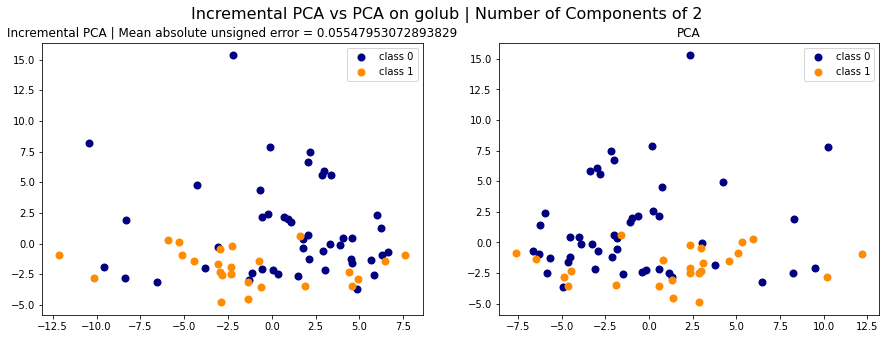

In [18]:
# to plot the results in one figure
for configuration in medical_data:
    X, y = medical_data[configuration]
    y =  np.where(y == -1, 0, y)
    
    # we use sklearn's implementation of pca and ipca
    ipca = IncrementalPCA(n_components=n_components, batch_size=10)
    X_ipca = ipca.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # current plot
    plt.figure(figsize=(15, 5))
    plt.suptitle("Incremental PCA vs PCA on "+ configuration +" | Number of Components of "+str(n_components), fontsize=16)
    
    
    for i, (X_transformed, title) in enumerate([(X_ipca, "Incremental PCA"), (X_pca, "PCA")]):
        ax = plt.subplot(1, 2, i+1)
        plot_title = title
        
        for color, i, target_name in zip(colors, [0, 1], ["class 0", "class 1"]):
            plt.scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                        color=color, lw=2, label=target_name)

        if "Incremental" in title:
            err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
            plot_title += " | Mean absolute unsigned error = " + str(err)
        ax.set_title(plot_title)
        plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()
    

## 3-2- With a number of componenets of 3 :

In [19]:
# Number of componenets to use
n_components = 3
# Labels for each class in the two datasets (for plotting purposes)
labels = {"breast" : [('class 1', 0), ('class 2', 1)], "golub" : [('class 1', 0), ('class 2', 1)]}

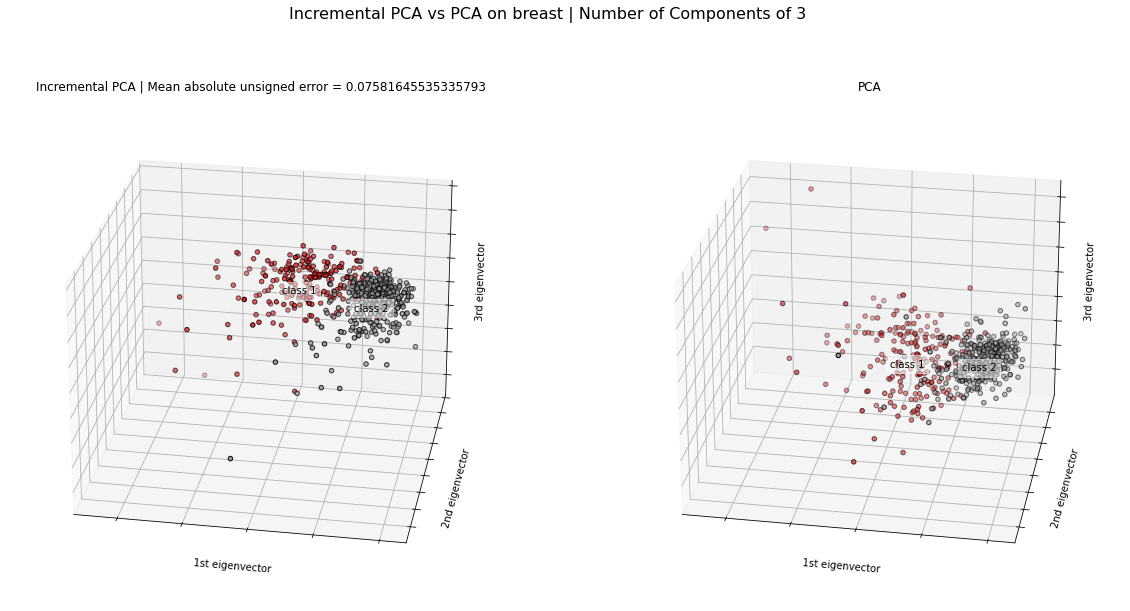

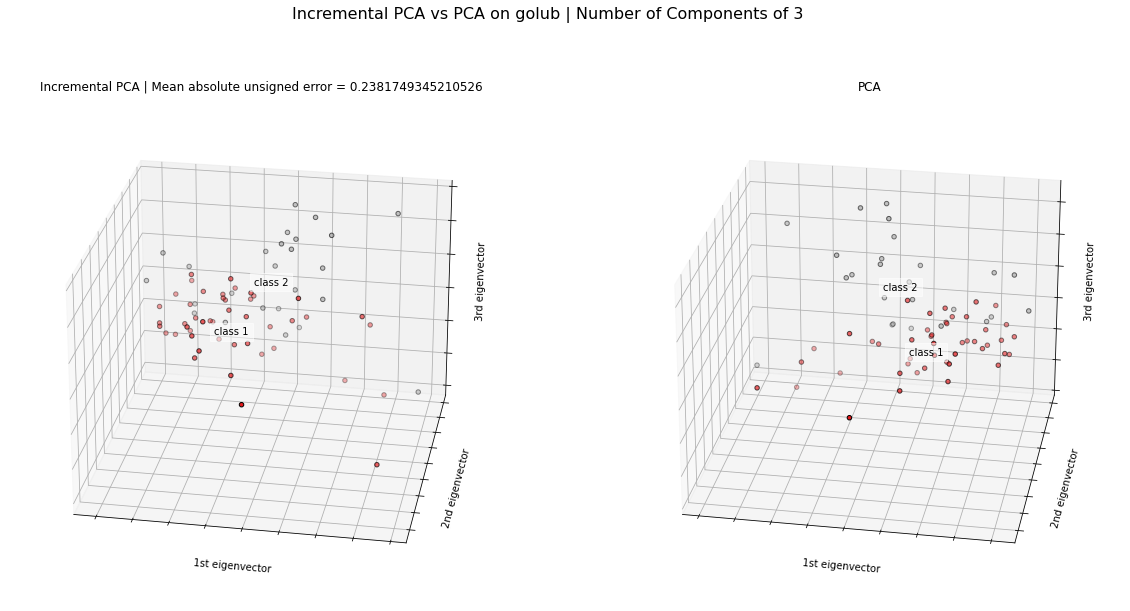

In [20]:
# to plot the results in one figure
for configuration in medical_data:
    X, y = medical_data[configuration]
    y =  np.where(y == -1, 0, y)
    
    # we use sklearn's implementation of pca and ipca
    ipca = IncrementalPCA(n_components=n_components, batch_size=10)
    X_ipca = ipca.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # current plot
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle("Incremental PCA vs PCA on "+ configuration +" | Number of Components of "+str(n_components), fontsize=16)
    
    
    for i, (X_transformed, title) in enumerate([(X_ipca, "Incremental PCA"), (X_pca, "PCA")]):
        ax = plt.subplot(1, 2, i+1)
        plot_title = title
            

        if "Incremental" in title:
            err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
            plot_title += " | Mean absolute unsigned error = " + str(err)
            
        visiualise_3D_clustering(X_transformed, y, fig=fig, position = 12*10+(i+1), title = plot_title, labels = labels[configuration])
        ax.set_title(plot_title)
plt.show()

> We observe a higher mean absolute error with a number of componenets of $3$.

# 4 - Classification after PCA :
> In this section, the goal is to classofy our haigh dimensional data. We will see if reducing the dimension of probelem with PCA, before fitting our classifier enhances it's preformance. We will test this approach on two classifiers, namely : a **support vector machine with an rbf kernel** and **logistic regression**. Concerning the number of PCA componenets, we'll test different values.

In [21]:
# the different componenets that we will test (-1 for no pca) :
n_componenets = [-1, 2, 5, 10, 20]
#  different classifiers that we will test :
clfs = {"logistic regression":LogisticRegression(random_state=0), "SVM with rbf kernel": svm.SVC(gamma='auto')}

In [22]:
# container for logging results
results = {}

In [23]:
from sklearn.model_selection import train_test_split
for configuration in medical_data:
    # get the data
    X, y = medical_data[configuration]
    y =  np.where(y == -1, 0, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # logging
    results[configuration] = {}
    for n_comp in n_componenets :
        # logging
        key = "No PCA" if n_comp == -1 else "PCA | "+str(n_comp)
        results[configuration][key] = {}
        
        # perform PCA
        if n_comp>0:
            pca = PCA(n_components=n_comp)
            pca.fit(X_train)
            X_pca_train = pca.transform(X_train)
            X_pca_test = pca.transform(X_test)   
        else:
            X_pca_train = X_train
            X_pca_test = X_test
            
        for clf_name in clfs:            
            # fit, predict and score
            clf = clfs[clf_name]
            clf.fit(X_pca_train, y_train)
            results[configuration][key][clf_name] = clf.score(X_pca_test, y_test)

In [24]:
def plot_bar_from_dict(D):
    """
    create bar plot with matplotlib from dictionary
    :param dictionary: input dictionary (key is an str, value is a number)
    """
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))

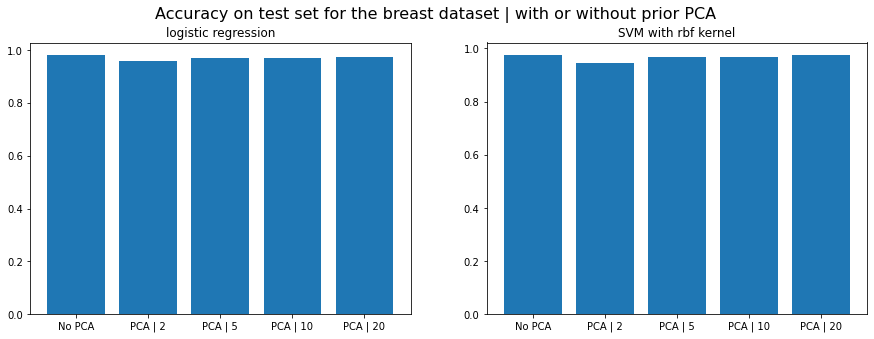

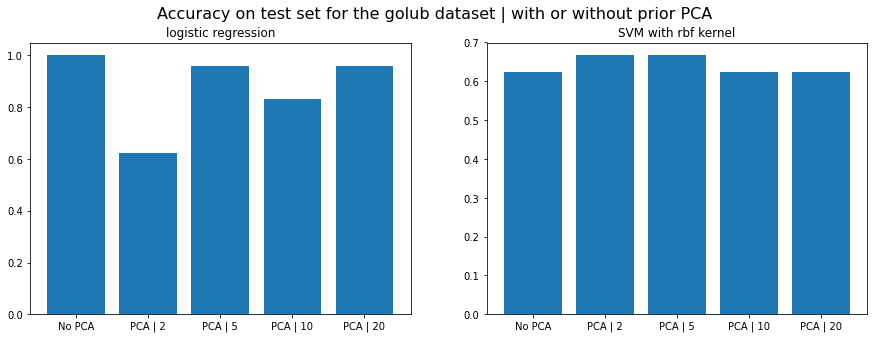

In [25]:
# plotting the results
# to plot the results in one figure
from collections import defaultdict
for configuration in results:
    plt.figure(figsize=(15, 5))
    plt.suptitle("Accuracy on test set for the "+configuration+" dataset | with or without prior PCA", fontsize=16)
    
    # get the results
    res = results[configuration]
    # invert the dictionary to get {"clf": {nb_cmp : acc}}
    flipped = defaultdict(dict)
    for key, val in res.items():
        for subkey, subval in val.items():
            flipped[subkey][key] = subval
    flipped = dict(flipped)
    for i,classifier in enumerate(flipped):
        # current plot
        ax = plt.subplot(1, 2, i+1)
        ax.set_title(str(classifier))
        # plot accuracy on test
        plot_bar_from_dict(flipped[classifier])
plt.show()

> We can see that for the SVM with rbf kernel on the golub dataset, PCA in fact enhances the results. Other than this case we observe no amelioration and a deterioration of performances in some cases.
> From our experiments (silhouette coefficient and accuracy with different classifiers), it appears that the Breast cancer dataset is better separated and easier for prediction. 

## 4 - bis - How to select the number of components :
> In order to select the number of componennts to use we need to estimate how many components are needed to describe the data. We will look at the cumulative explained variance ratio as a function of the number of components. We then select the minimum number of compoenets that account's for a fixed threshold, let's say $0.95$.

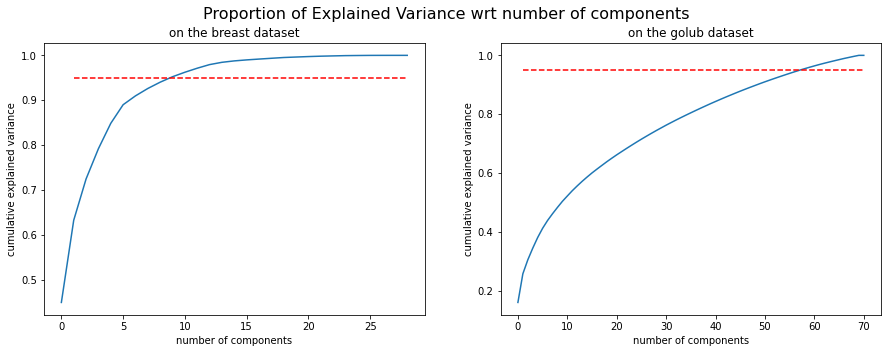

In [26]:
# plot
plt.figure(figsize=(15, 5))
plt.suptitle("Proportion of Explained Variance wrt number of components ", fontsize=16)
for i,configuration in enumerate(medical_data):
    # get the data
    X, y = medical_data[configuration]
    y =  np.where(y == -1, 0, y) 
    pca = PCA().fit(X)
    ax = plt.subplot(1, 2, i+1)
    ax.set_title("on the "+str(configuration)+" dataset")
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    xs = np.arange(1, len(pca.explained_variance_ratio_))
    threshold = np.array([0.95 for i in range(len(pca.explained_variance_ratio_)-1)])
    plt.plot(xs, threshold, 'r--') 
    plt.plot()
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

> So to get a minimum of variance accounted for of $0.95$, we would take $\approx 8$ component for the breast dataset and $\approx 55$ components for the golub dataset.

# 5 - Comparison between LDA and PCA :

> In this section we will compare between PCA and LDA. In fact, PCA tries to find directions which maximise the variance while LDA identifies features that account for the most varaiance between classes.

# 5 - 1 - With a number of components of 2 :

In [27]:
# number of componenets to use 
n_components = 1

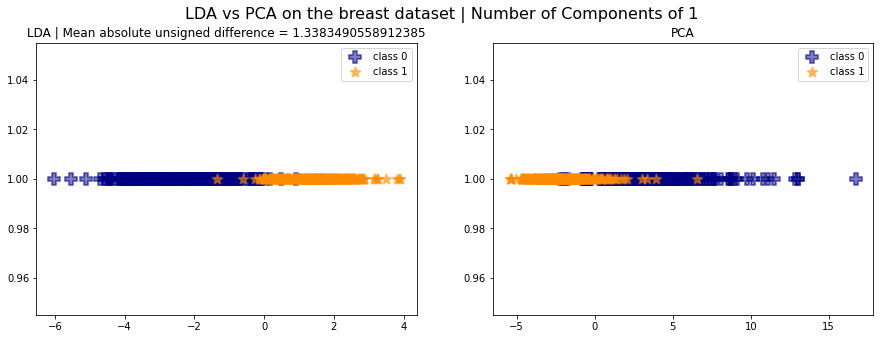

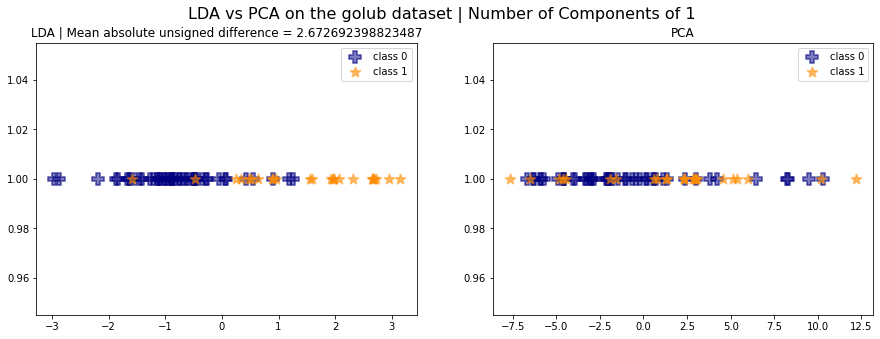

In [28]:
# to plot the results in one figure
for configuration in medical_data:
    X, y = medical_data[configuration]
    y =  np.where(y == -1, 0, y)
    
    # we use sklearn's implementation of PCA and LDA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit(X, y).transform(X)
    
    # current plot
    plt.figure(figsize=(15, 5))
    plt.suptitle("LDA vs PCA on the "+ configuration +" dataset | Number of Components of "+str(n_components), fontsize=16)
    
    
    for i, (X_transformed, title) in enumerate([(X_lda, "LDA"), (X_pca, "PCA")]):
        ax = plt.subplot(1, 2, i+1)
        plot_title = title
        
        for color, i, target_name in zip(colors, [0, 1], ["class 0", "class 1"]):
            marker = "P" if i==0 else "*"
            plt.scatter(X_transformed[y == i, 0], np.ones_like(X_transformed[y == i, 0]),\
                        marker = marker, color=color, lw=2, label=target_name, alpha = 0.5, s = 50*(1-i+1)+50)

        if "LDA" in title:
            err = np.abs(np.abs(X_pca) - np.abs(X_lda)).mean()
            plot_title += " | Mean absolute unsigned difference = " + str(err)
        ax.set_title(plot_title)
        plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()

> We can see visually that LDA yields a better separability for both datasets.